--- Generating Calibration Data ---
--- Analyzing Results ---
Result | Gain: 2.509 e-/ADU (Target: 2.5)
Result | Read Noise: 5.225 e- (Target: 5.0)
Result | Dark Current: 9.537 e-/s (Target: 9.5)


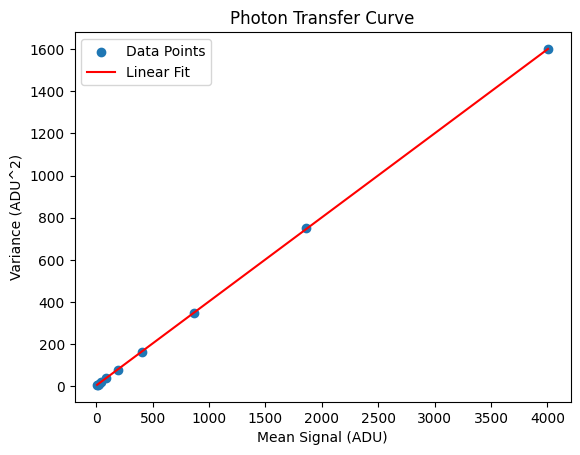

In [28]:
import numpy as np
import matplotlib.pyplot as plt

class DetectorAnalysis:
    def __init__(self, shape=(512, 512)):
        self.shape = shape

    # --- 1. STATISTICAL ANALYSIS METHODS ---

    def estimate_read_noise(self, bias1, bias2, gain_estimate):
        """
        Calculates Read Noise in electrons using the difference of two zero-exposure frames.
        """
        diff = bias1 - bias2
        # std of difference is sqrt(2) * std of single frame
        rms_adu = np.std(diff) / np.sqrt(2)
        return rms_adu * gain_estimate

    def estimate_gain_ptc(self, flat_pairs):
        """
        Uses the Photon Transfer Curve (PTC) method.
        flat_pairs: List of tuples (FrameA, FrameB) at increasing light levels.
        Returns: Gain (e-/ADU) and Read Noise (e-)
        """
        means = []
        variances = []

        for f1, f2 in flat_pairs:
            # 1. Calculate the mean of the two frames (in ADU)
            mean_adu = np.mean((f1 + f2) / 2.0)
            
            # 2. Subtract frames to remove fixed-pattern noise (Flat Field)
            diff = f1 - f2
            # Variance of difference is 2 * Variance of shot noise
            var_adu = np.var(diff) / 2.0
            
            means.append(mean_adu)
            variances.append(var_adu)

        # 3. Linear Fit: Variance = (1/Gain) * Mean + Offset
        # We only fit the linear part (avoiding saturation or read-noise floor)
        slope, intercept = np.polyfit(means, variances, 1)
        
        gain = 1.0 / slope
        read_noise_e = np.sqrt(max(0, intercept)) * gain
        
        return gain, read_noise_e, (means, variances)

    def estimate_dark_current(self, dark_frames, exposure_times, gain):
        """
        Calculates dark current (e-/pix/sec) using mean signal vs time.
        """
        means_e = [np.mean(f) * gain for f in dark_frames]
        slope, _ = np.polyfit(exposure_times, means_e, 1)
        return slope

# --- 2. DATA GENERATION (Simulating the Hardware) ---

# Ground Truth Parameters (What we want the script to find)
TRUE_GAIN = 2.5       # e-/ADU
TRUE_RON = 5.0        # e-
TRUE_DARK = 9.5       # e-/sec
FLAT_SIGMA = 0.05     # 5% pixel-to-pixel variation

def get_raw_frame(light_level, time, flat_map):
    # Physics pipeline
    signal = (light_level + TRUE_DARK) * time * flat_map
    electrons = np.random.poisson(signal) + np.random.normal(0, TRUE_RON, signal.shape)
    return (electrons / TRUE_GAIN).astype(np.float32)

# --- 3. RUNNING THE EXPERIMENT ---

analyzer = DetectorAnalysis()
flat_field_map = np.random.normal(1.0, FLAT_SIGMA, (512, 512))

print("--- Generating Calibration Data ---")

# A. Generate Flat Pairs for Gain/PTC (increasing light from 10 to 10000 photons)
ptc_data = []
for level in np.logspace(1, 4, 10):
    f1 = get_raw_frame(level, 1.0, flat_field_map)
    f2 = get_raw_frame(level, 1.0, flat_field_map)
    ptc_data.append((f1, f2))

# B. Generate Dark Frames for Dark Current
dark_times = [1, 5, 10, 20]
darks = [get_raw_frame(0, t, flat_field_map) for t in dark_times]

print("--- Analyzing Results ---")

# Perform Analysis
est_gain, est_ron, ptc_points = analyzer.estimate_gain_ptc(ptc_data)
est_dark = analyzer.estimate_dark_current(darks, dark_times, est_gain)

print(f"Result | Gain: {est_gain:.3f} e-/ADU (Target: {TRUE_GAIN})")
print(f"Result | Read Noise: {est_ron:.3f} e- (Target: {TRUE_RON})")
print(f"Result | Dark Current: {est_dark:.3f} e-/s (Target: {TRUE_DARK})")

# Visualize the PTC
m, v = ptc_points
plt.scatter(m, v, label='Data Points')
plt.plot(m, np.polyval(np.polyfit(m, v, 1), m), color='red', label='Linear Fit')
plt.xlabel('Mean Signal (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.title('Photon Transfer Curve')
plt.legend()
plt.show()

--- Simulating 8-bit Sensor ---

[RESULTS]
Gain:       Target 1.500 | Measured 1.485 e-/ADU
Read Noise: Target 5.000 | Measured 4.609 e-
Dark Rate:  Target 3.000 | Measured 2.912 e-/s


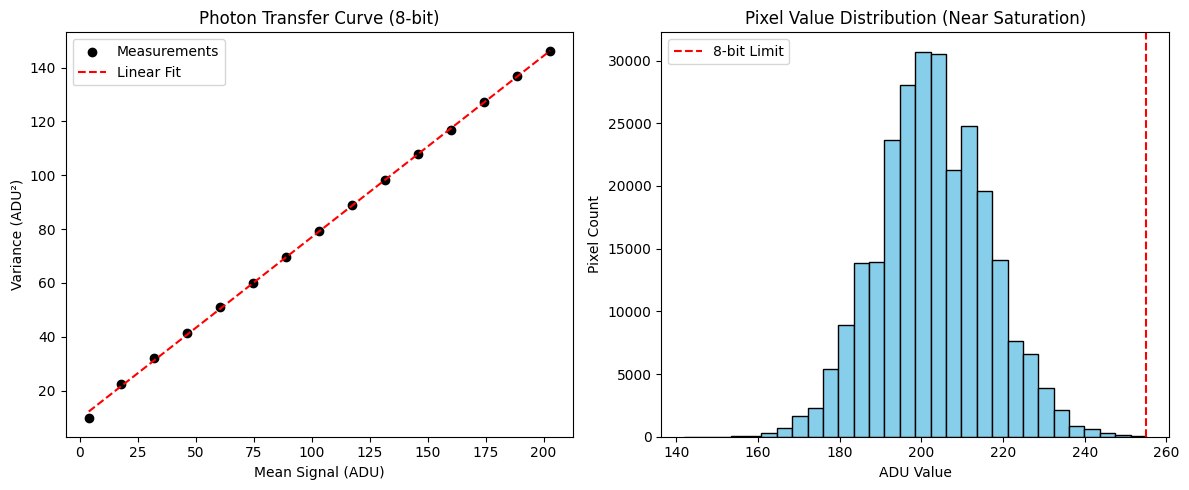

In [29]:
import numpy as np
import matplotlib.pyplot as plt

class PhysicalDetector:
    """
    A physics-based model of a CMOS/CCD sensor.
    Converts Photons -> Electrons -> ADU (Digital Counts)
    """
    def __init__(self, shape=(512, 512), gain=2.0, read_noise=3.5, 
                 dark_rate=1.2, flat_sigma=0.03, bit_depth=8):
        self.shape = shape
        self.gain = gain           # Electrons per ADU
        self.read_noise = read_noise # Electrons (RMS)
        self.dark_rate = dark_rate   # Electrons/pix/sec
        self.bit_depth = bit_depth
        self.max_adu = 2**bit_depth - 1
        
        # Fixed Pattern Noise: Pixel-to-pixel sensitivity map
        self.flat_field = np.random.normal(1.0, flat_sigma, shape)

    def capture(self, flux_field, exposure_time):
        """
        The Forward Physics Model:
        1. Photons + Thermal -> Poisson Noise (Shot Noise)
        2. Electronic Noise -> Gaussian Noise (Read Noise)
        3. Quantization -> Clipping & Bit-depth mapping
        """
        # --- A. ELECTRON GENERATION ---
        # Expected mean electrons = (Light + Dark) * Time * Sensitivity
        mu = (flux_field + self.dark_rate) * exposure_time * self.flat_field
        
        # Shot Noise (Poisson)
        electrons = np.random.poisson(mu).astype(float)
        
        # --- B. READOUT ---
        # Electronic Read Noise (Gaussian)
        electrons += np.random.normal(2, self.read_noise, self.shape)
        
        # --- C. DIGITIZATION (ADC) ---
        # Convert to ADU (Gain)
        adu = electrons / self.gain
        
        # Clipping: Values must be within [0, 2^bit_depth - 1]
        clipped_adu = np.clip(adu, 0, self.max_adu)
        
        # Quantization: Converting to integers
        return np.floor(clipped_adu).astype(np.uint16)

class SensorLab:
    """Statistical tools to analyze raw sensor frames."""
    
    @staticmethod
    def analyze_gain_and_ron(flat_pairs):
        """
        PTC Method: Uses pairs of identical flats to isolate random noise.
        Formula: Var(ADU) = (1/Gain) * Mean(ADU) + Constant
        """
        means = []
        variances = []
        
        for f1, f2 in flat_pairs:
            # We use float32 to prevent wrap-around errors during subtraction
            f1, f2 = f1.astype(np.float32), f2.astype(np.float32)
            
            mean_adu = np.mean((f1 + f2) / 2.0)
            
            # Variance calculation (Difference method removes Fixed Pattern Noise)
            diff = f1 - f2
            var_adu = np.var(diff) / 2.0
            
            # Only include non-saturated data (below 90% of max range)
            if mean_adu < (np.max(f1) * 0.9) and mean_adu > 0:
                means.append(mean_adu)
                variances.append(var_adu)

        # Linear fit: y = mx + c  => Var = (1/G)*Mean + Var_read
        slope, intercept = np.polyfit(means, variances, 1)
        
        recovered_gain = 1.0 / slope
        recovered_ron = np.sqrt(max(0, intercept)) * recovered_gain
        
        return recovered_gain, recovered_ron, (means, variances)

    @staticmethod
    def analyze_dark_current(dark_frames, times, gain):
        """Slope of Mean(Electrons) vs Time."""
        means_e = [np.mean(f) * gain for f in dark_frames]
        slope, _ = np.polyfit(times, means_e, 1)
        return slope

# --- EXECUTION SCRIPT ---

# 1. Setup Ground Truth
GT_GAIN = 1.5      # e-/ADU
GT_RON = 5.0       # Electrons
GT_DARK = 3.0      # e-/s
GT_BITS = 8        # 0-255 range

camera = PhysicalDetector(gain=GT_GAIN, read_noise=GT_RON, 
                          dark_rate=GT_DARK, bit_depth=GT_BITS)

print(f"--- Simulating {GT_BITS}-bit Sensor ---")

# 2. Collect Data: PTC Pairs (Varying intensity)
# We test levels from low light to near saturation
intensities = np.linspace(1, 300, 15)
flat_pairs = []
for intensity in intensities:
    f1 = camera.capture(intensity, 1.0)
    f2 = camera.capture(intensity, 1.0)
    flat_pairs.append((f1, f2))

# 3. Collect Data: Dark frames (Varying time)
dark_times = [0, 5, 10, 20]
darks = [camera.capture(0, t) for t in dark_times]

# 4. Perform Analysis
lab = SensorLab()
est_gain, est_ron, ptc_data = lab.analyze_gain_and_ron(flat_pairs)
est_dark = lab.analyze_dark_current(darks, dark_times, est_gain)

# --- OUTPUT ---
print(f"\n[RESULTS]")
print(f"Gain:       Target {GT_GAIN:.3f} | Measured {est_gain:.3f} e-/ADU")
print(f"Read Noise: Target {GT_RON:.3f} | Measured {est_ron:.3f} e-")
print(f"Dark Rate:  Target {GT_DARK:.3f} | Measured {est_dark:.3f} e-/s")

# Visualize Clipping and PTC
plt.figure(figsize=(12, 5))

# Plot 1: The PTC curve
plt.subplot(1, 2, 1)
m, v = ptc_data
plt.scatter(m, v, color='black', label='Measurements')
plt.plot(m, np.polyval(np.polyfit(m, v, 1), m), 'r--', label='Linear Fit')
plt.title(f"Photon Transfer Curve ({GT_BITS}-bit)")
plt.xlabel("Mean Signal (ADU)")
plt.ylabel("Variance (ADU²)")
plt.legend()

# Plot 2: Histogram showing the 0-255 limit
plt.subplot(1, 2, 2)
plt.hist(flat_pairs[-1][0].flatten(), bins=30, color='skyblue', edgecolor='black')
plt.axvline(2**GT_BITS - 1, color='red', linestyle='--', label='8-bit Limit')
plt.title("Pixel Value Distribution (Near Saturation)")
plt.xlabel("ADU Value")
plt.ylabel("Pixel Count")
plt.legend()

plt.tight_layout()
plt.show()

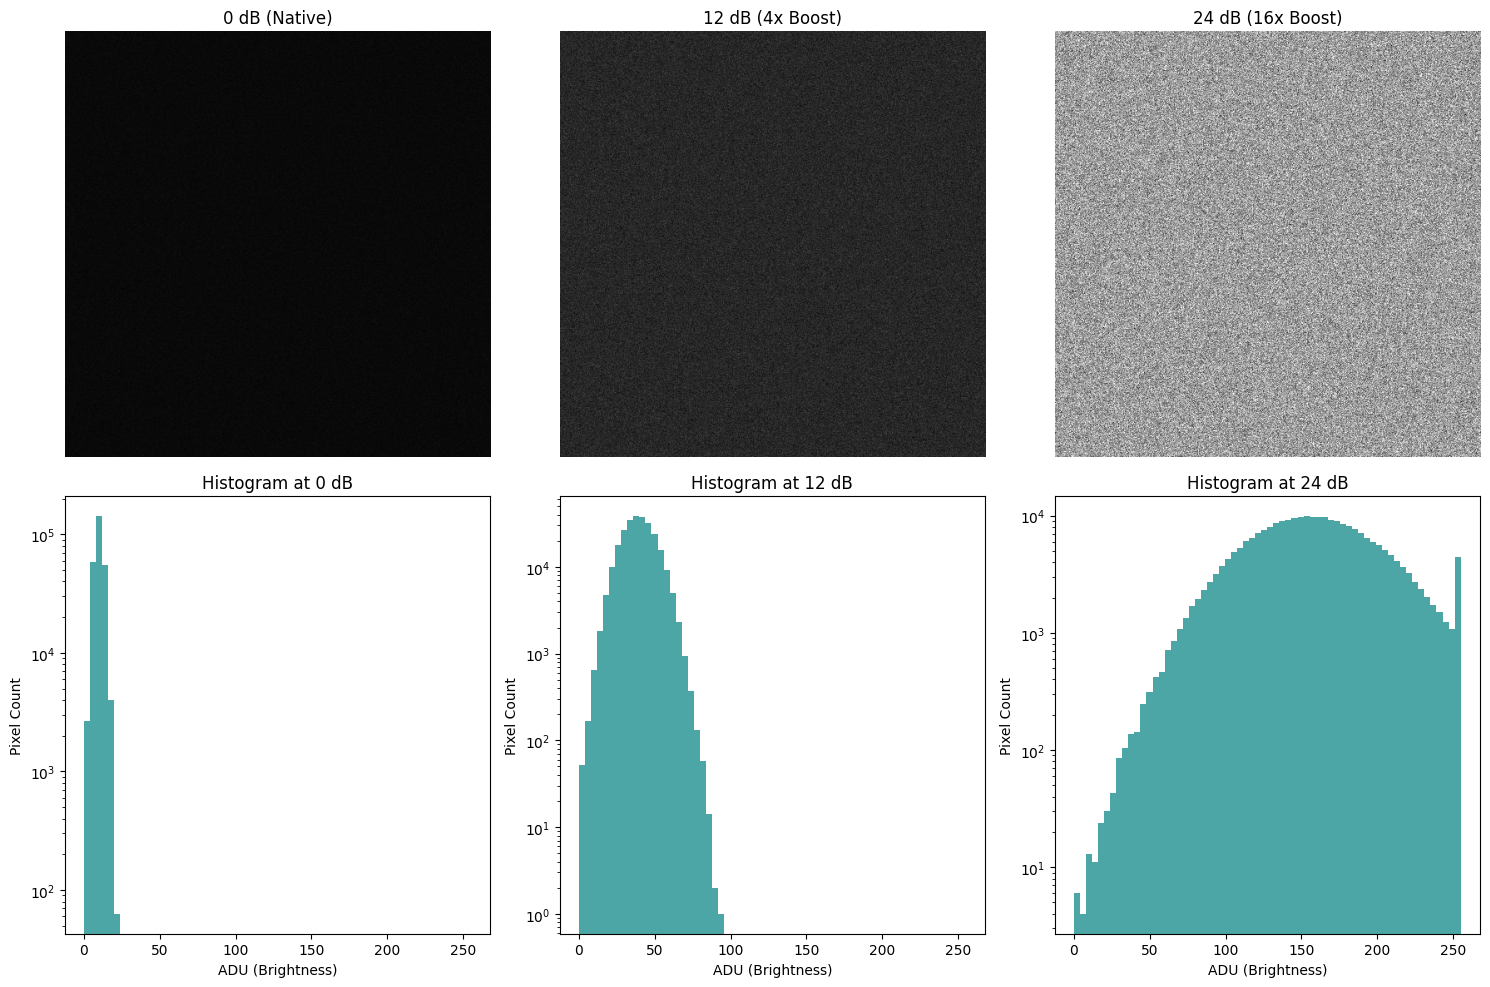

SNR at 0 dB:  3.519
SNR at 12 dB: 3.631
SNR at 24 dB: 3.740


In [30]:
'''some discussion on SNR and gain adjustment in cameras'''


import numpy as np
import matplotlib.pyplot as plt

class ProfessionalCamera:
    def __init__(self, shape=(512, 512), base_gain=2, read_noise_e=3.0, bit_depth=8):
        self.shape = shape
        self.base_gain = base_gain      # The 'Native' e-/ADU
        self.read_noise_e = read_noise_e # Electronic noise in electrons
        self.bit_depth = bit_depth
        self.max_adu = 2**bit_depth - 1

    def capture(self, flux, exposure, gain_db=0):
        # 1. Physics: Generate Electrons (Signal + Poisson Noise)
        mean_e = flux * exposure
        electrons = np.random.poisson(mean_e, self.shape).astype(float)
        
        # 2. Add Read Noise (In electrons)
        electrons += np.random.normal(0, self.read_noise_e, self.shape)
        
        # 3. Apply dB Gain (Electronic Amplification)
        # Multiplier A = 10^(dB/20)
        multiplier = 10**(gain_db / 20)
        
        # 4. Digitization
        # The effective gain is the base gain divided by our multiplier
        effective_gain = self.base_gain / multiplier
        
        adu = electrons / effective_gain
        
        # 5. ADC Clipping & Quantization
        clipped = np.clip(adu, 0, self.max_adu)
        return clipped.astype(np.uint16)

# --- Simulation Execution ---

cam = ProfessionalCamera()
flux_level = 20  # Constant low-light scene
exposure = 1.0

# Capture images at different dB levels
img_0db = cam.capture(flux_level, exposure, gain_db=0)
img_12db = cam.capture(flux_level, exposure, gain_db=12) # ~4x brighter
img_24db = cam.capture(flux_level, exposure, gain_db=24) # ~16x brighter

# --- Visualization ---

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top Row: The Images
titles = ["0 dB (Native)", "12 dB (4x Boost)", "24 dB (16x Boost)"]
images = [img_0db, img_12db, img_24db]

for ax, img, title in zip(axes[0], images, titles):
    ax.imshow(img, cmap='gray', vmin=0, vmax=2**8-1)
    ax.set_title(title)
    ax.axis('off')

# Bottom Row: The Histograms (The Math in action)
for ax, img, db in zip(axes[1], images, [0, 12, 24]):
    ax.hist(img.flatten(), bins=64, range=(0, 2**8-1), color='teal', alpha=0.7)
    ax.set_title(f"Histogram at {db} dB")
    ax.set_xlabel("ADU (Brightness)")
    ax.set_ylabel("Pixel Count")
    ax.set_yscale('log') # Log scale helps see the noise spread

plt.tight_layout()
plt.show()



def calculate_snr(image):
    # We use a small patch in the center to avoid edge effects
    patch = image[200:300, 200:300].astype(np.float32)
    mean_signal = np.mean(patch)
    std_noise = np.std(patch)
    
    # Avoid division by zero
    if std_noise == 0: return 0
    return mean_signal / std_noise

# Calculate for our simulated images
snr_0 = calculate_snr(img_0db)
snr_12 = calculate_snr(img_12db)
snr_24 = calculate_snr(img_24db)

print(f"SNR at 0 dB:  {snr_0:.3f}")
print(f"SNR at 12 dB: {snr_12:.3f}")
print(f"SNR at 24 dB: {snr_24:.3f}")

## I still need to develop some understanding

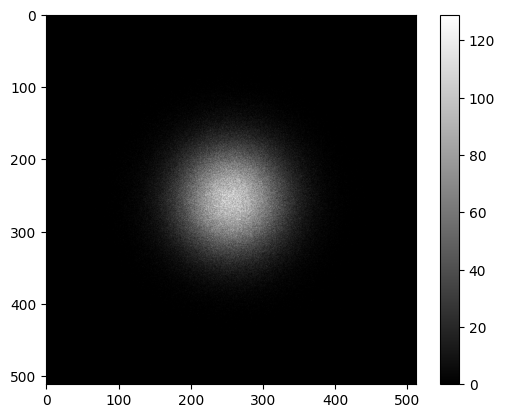

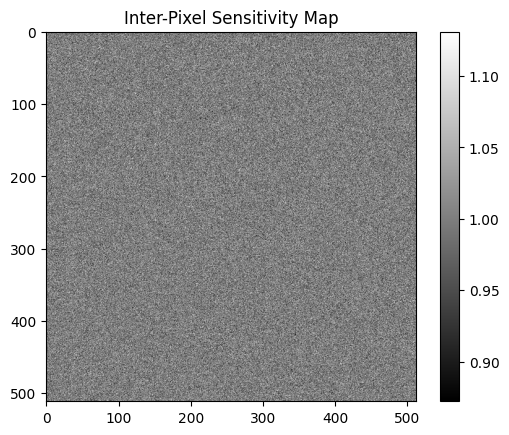

0.8723312196049839 1.1310445830102154
0.030080015161911278
1.0000029441362954


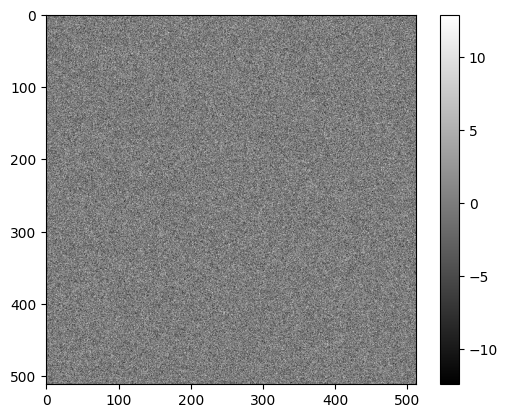

-12.403016444306564 12.891493709811787
2.9999190690208923
-0.00557437052971266


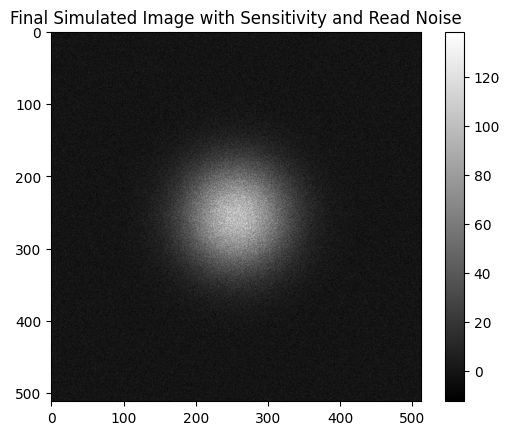

-12.403016444306564 138.58156904650244


In [182]:
detector_array_shape = (512, 512)

def generate_inter_pix_sensitivity(shape, sigma, seed):
    rng = np.random.default_rng(seed=seed)
    return rng.normal(1.0, sigma, shape)

def generate_read_noise(shape, dc_dias, ron, seed):
    rng = np.random.default_rng(seed=seed)
    return rng.normal(dc_dias, ron, shape)

def generate_poisson_noise(image_array, shape, seed):
    rng = np.random.default_rng(seed=seed)
    return rng.poisson(image_array, shape).astype(float)

def generate_gaussian_2d(size=512, sigma=1):
    x = np.linspace(0, size - 1, size)
    y = np.linspace(0, size - 1, size)
    x, y = np.meshgrid(x, y)
    # Define center
    mu_x, mu_y = size // 2, size // 2
    # Calculate the Gaussian map
    gaussian_map = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))
    return gaussian_map

# def generate_flat_frames(uniform_flux, exposure_time, dark_rate):
#     mu = (uniform_flux + dark_rate) * exposure_time
#     return np.random.poisson(mu, (512, 512)).astype(float)

    



sensitivity_seed = 10
read_noise_seed = 20
poisson_seed = 42

gaussian_2d = generate_gaussian_2d(512, sigma=50)
mu = gaussian_2d * 100  # Scale to desired photon level
image_array = mu

C = generate_poisson_noise(image_array, detector_array_shape, seed=poisson_seed)
plt.imshow(C, cmap='gray')
plt.colorbar()
plt.show()

A = generate_inter_pix_sensitivity(detector_array_shape, 0.03, seed=sensitivity_seed)
plt.imshow(A, cmap='gray')
plt.colorbar()
plt.title("Inter-Pixel Sensitivity Map")
plt.show()  
print(min(A.flatten()), max(A.flatten()))
print(np.std(A.flatten()))
print(np.mean(A.flatten()))

B = generate_read_noise(detector_array_shape, dc_dias=0, ron=3, seed=read_noise_seed)
plt.imshow(B, cmap='gray')
plt.colorbar()
plt.show()
print(min(B.flatten()), max(B.flatten()))
print(np.std(B.flatten()))
print(np.mean(B.flatten()))

complete_image = A * C + B  # final image after sensitivity and read noise
plt.imshow(complete_image, cmap='gray')
plt.colorbar()
plt.title("Final Simulated Image with Sensitivity and Read Noise")
plt.show()
print(min(complete_image.flatten()), max(complete_image.flatten()))





# # poisson noise stat (source + dark)
# flux_field = 20  # photons/pixel/sec
# exposure_time = 1.0  # seconds
# dark_rate = 1.2  # electrons/pixel/sec
# mu = (flux_field + dark_rate) * exposure_time

# # C = np.random.poisson(mu, (512, 512)).astype(float)
# C = np.random.poisson(flux_field * exposure_time, (512, 512)).astype(float) + np.random.poisson(dark_rate * exposure_time, (512, 512)).astype(float)
# # adding the distributions or creating a distribution from addition is the same for poisson

# plt.imshow(C, cmap='gray')
# plt.colorbar()
# plt.show()
# print(min(C.flatten()), max(C.flatten()))
# print(np.std(C.flatten()))
# print(np.mean(C.flatten()))

# print(np.sqrt(mu))  # theoretical shot noise RMS




In [183]:
bit_depth = 8
max_adu = 2**bit_depth - 1
full_well_capacity = 15000  # e-
# full_well_capacity = max_adu * gain_optimum
# max_adu = 2**bit_depth - 1
gain_optimum = full_well_capacity / max_adu  # e-/ADU
print(gain_optimum)

# gain_dB is an user input in dB scale
gain_dB = 20  # dB
gain = gain_optimum / (10**(gain_dB / 20))
print(gain)  # e-/ADU

read_noise_e = 3
dynamic_range_dB = 20 * np.log10(full_well_capacity / read_noise_e)
print(dynamic_range_dB)  # dB


58.8235294117647
5.88235294117647
73.97940008672037


In [184]:
## does dc bias come before or after gain and is it a part of read noise or separate ?

/var/folders/82/4_zfr0ld1js5_5zv4y2mzvs00000gn/T/ipykernel_16051/1885555102.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


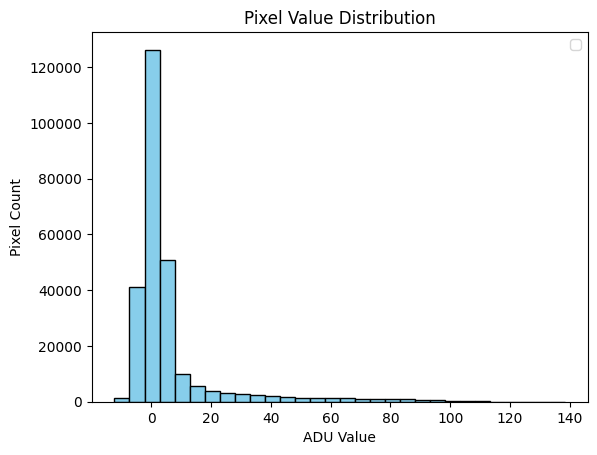

In [185]:
plt.hist(complete_image.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Pixel Value Distribution")
plt.xlabel("ADU Value")
plt.ylabel("Pixel Count")
plt.legend()
plt.show()

58.8235294117647
0.5882352941176471


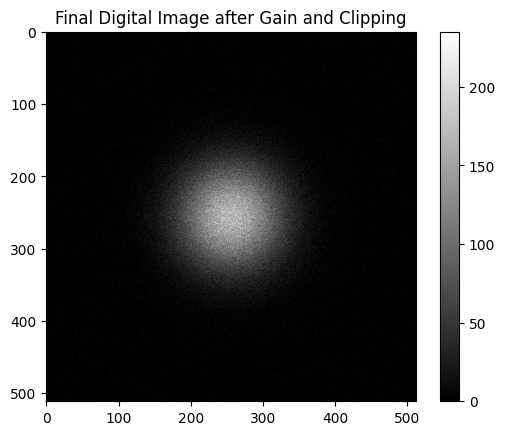

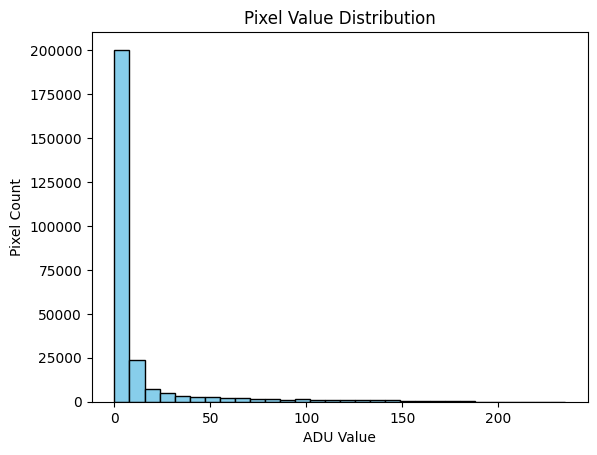

In [186]:
def electron_to_adu_converter(electrons, gain):
    return electrons / gain
def adu_clipper(adu_values, bit_depth):
    max_adu = 2**bit_depth - 1
    clipped_adu = np.clip(adu_values, 0, max_adu)
    whole_clipeed_adu = np.floor(clipped_adu).astype(np.uint16)
    return whole_clipeed_adu

bit_depth = 8
max_adu = 2**bit_depth - 1
full_well_capacity = 15000  
gain_optimum = full_well_capacity / max_adu  # e-/ADU
print(gain_optimum)
gain_dB = 40  # dB
gain = gain_optimum / (10**(gain_dB / 20))
print(gain)  # e-/ADU

# keep gain_dB high in low light condition, but if too high, clipping would happen

digital_image = electron_to_adu_converter(complete_image, gain)
final_digital_image = adu_clipper(digital_image, bit_depth)
plt.imshow(final_digital_image, cmap='gray')
plt.colorbar()
plt.title("Final Digital Image after Gain and Clipping")
plt.show()


plt.hist(final_digital_image.flatten(), bins=30, color='skyblue', edgecolor='black')
# plt.axvline(2**bit_depth - 1, color='red', linestyle='--', label='8-bit Limit')
plt.title("Pixel Value Distribution")
plt.xlabel("ADU Value")
plt.ylabel("Pixel Count")
# plt.legend()
plt.show()


In [187]:
print(final_digital_image.shape)

(512, 512)


In [188]:
# examle operation of np.clip
a = np.linspace(-100, 300, 10)
clipped_values = np.clip(a, 0, 200)
print(clipped_values)

print(np.floor(2.8))

[  0.           0.           0.          33.33333333  77.77777778
 122.22222222 166.66666667 200.         200.         200.        ]
2.0


# Below is a complete sensor package

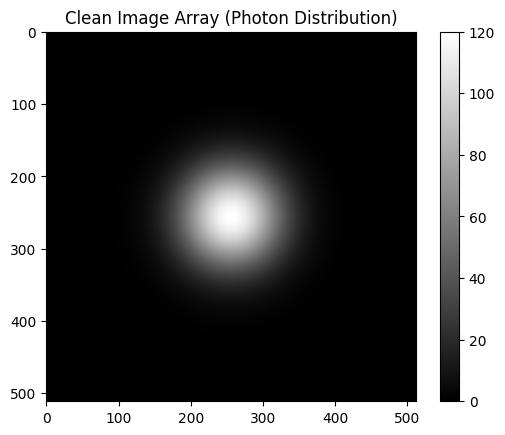

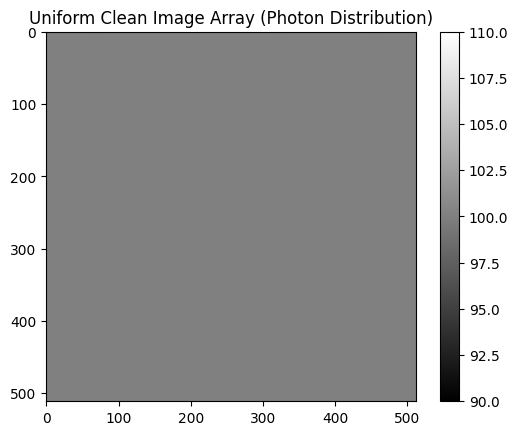

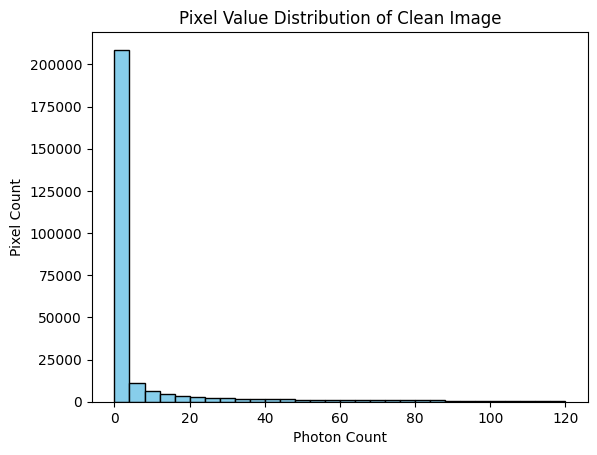

In [214]:
'''
clean image generation onto which noise will be added
'''

import numpy as np
import matplotlib.pyplot as plt

def generate_gaussian_2d(size=512, sigma=1):
    x = np.linspace(0, size - 1, size)
    y = np.linspace(0, size - 1, size)
    x, y = np.meshgrid(x, y)
    # Define center
    mu_x, mu_y = size // 2, size // 2
    # Calculate the Gaussian map
    gaussian_map = np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2))
    return gaussian_map



# will be useful for demonstarting effects
gaussian_2d = generate_gaussian_2d(512, sigma=50)
gaussian_image_array = gaussian_2d * 120  # Scale to desired photon level
plt.imshow(gaussian_image_array, cmap='gray')
plt.colorbar()
plt.title("Clean Image Array (Photon Distribution)")
plt.show()


# will be useful for flat fielding
uniform_image_array = np.full((512, 512), 100.0)  # Uniform illumination at 100 photons/pixel
plt.imshow(uniform_image_array, cmap='gray')
plt.colorbar()
plt.title("Uniform Clean Image Array (Photon Distribution)")
plt.show()

plt.hist(gaussian_image_array.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Pixel Value Distribution of Clean Image")
plt.xlabel("Photon Count")
plt.ylabel("Pixel Count")
plt.show()



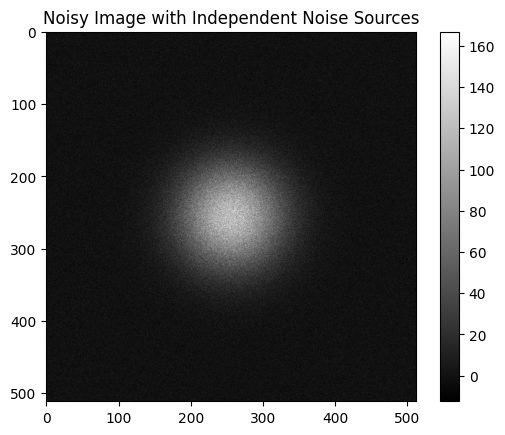

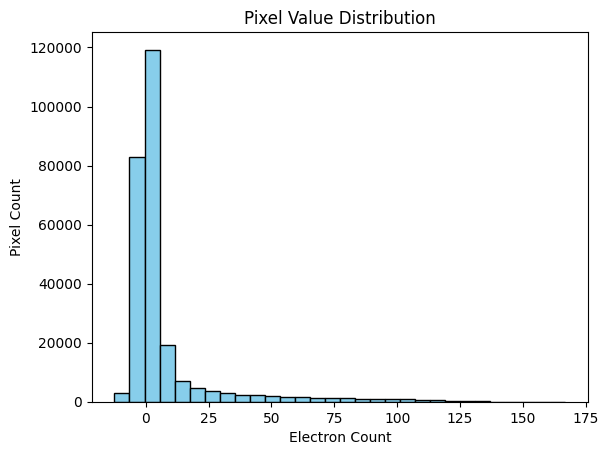

In [215]:

class SensorNoiseGenerator:
    def __init__(self, sens_sigma, read_sigma, dc_bias, clean_image_array, exp_t, dark_rate, 
                 sens_seed=None, read_seed=None, shot_seed=None, dark_seed=None):

        self.sens_sigma = sens_sigma
        self.read_sigma = read_sigma
        self.dc_bias = dc_bias
        self.clean_image_array = clean_image_array
        self.exp_t = exp_t
        self.dark_rate = dark_rate
        self.shape = clean_image_array.shape
        
        # Store seeds for reproducibility
        self.sens_seed = sens_seed
        self.read_seed = read_seed
        self.shot_seed = shot_seed
        self.dark_seed = dark_seed

    def _get_rng(self, seed):
        """Helper to manage independent RNG streams."""
        return np.random.default_rng(seed)

    def pixel_sensitivity(self):
        return self._get_rng(seed = self.sens_seed).normal(1.0, self.sens_sigma, self.shape)

    def read_noise(self):
        return self._get_rng(seed = self.read_seed).normal(self.dc_bias, self.read_sigma, self.shape)

    def shot_noise(self, arr=None):
        target = self.clean_image_array if arr is None else arr
        return self._get_rng(seed = self.shot_seed).poisson(target).astype(float)
    
    def dark_noise(self):
        mu_dark = self.dark_rate * self.exp_t
        return self._get_rng(seed = self.dark_seed).poisson(mu_dark, self.shape).astype(float)
    
    

    # Initialize
noise_gen = SensorNoiseGenerator(
    sens_sigma = 0.03, 
    read_sigma = 3.0, 
    dc_bias = 0, 
    clean_image_array = gaussian_image_array, 
    exp_t = 1.0, 
    dark_rate = 0, 
    sens_seed=10, read_seed=20, shot_seed=42, dark_seed=404
)

# Extract
sens = noise_gen.pixel_sensitivity()
read = noise_gen.read_noise()
shot = noise_gen.shot_noise()
dark = noise_gen.dark_noise()

noise_image_e = sens * (shot + dark) + read

plt.imshow(noise_image_e, cmap='gray')
plt.colorbar()
plt.title("Noisy Image with Independent Noise Sources")
plt.show()

plt.hist(noise_image_e.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Pixel Value Distribution")   
plt.xlabel("Electron Count")        
plt.ylabel("Pixel Count")   
plt.show()

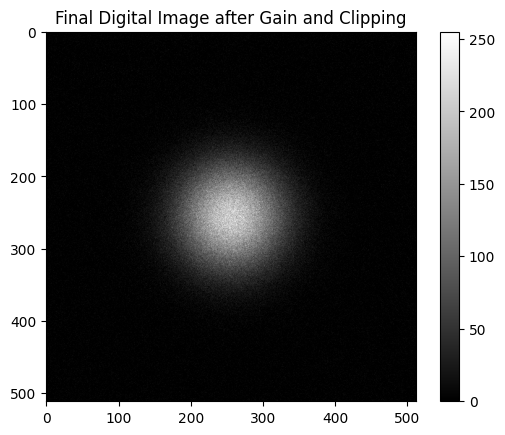

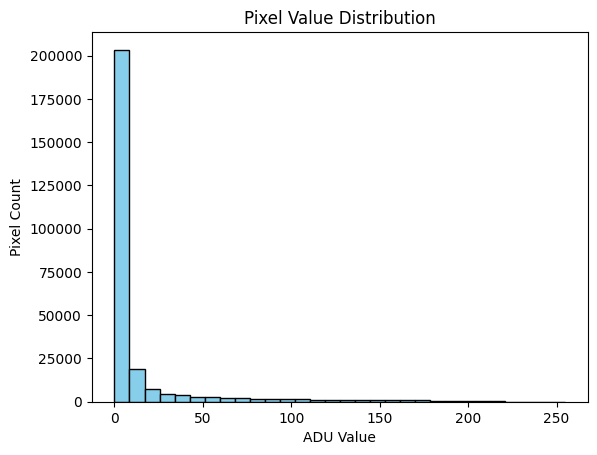

In [216]:
class SensorDigitizer:
    def __init__(self, bit_depth, gain_dB, full_well_capacity, image_electrons):

        self.max_adu = 2**bit_depth - 1
        self.full_well_capacity = full_well_capacity
        self.gain_optimum = full_well_capacity / self.max_adu  # e-/ADU
        self.gain = self.gain_optimum / (10**(gain_dB / 20))

        self.image_electrons = image_electrons

    def electron_to_adu_converter(self):
        return self.image_electrons / self.gain

    def adu_clipper(self):
        clipped_adu = np.clip(self.electron_to_adu_converter(), 0, self.max_adu)
        whole_clipeed_adu = np.floor(clipped_adu).astype(np.uint16)
        return whole_clipeed_adu
    

digitizer = SensorDigitizer(bit_depth=8, gain_dB=40, full_well_capacity=15000, image_electrons=noise_image_e)
final_digital_image = digitizer.adu_clipper()
plt.imshow(final_digital_image, cmap='gray')
plt.colorbar()
plt.title("Final Digital Image after Gain and Clipping")
plt.show()

plt.hist(final_digital_image.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.title("Pixel Value Distribution")   
plt.xlabel("ADU Value")
plt.ylabel("Pixel Count")   
plt.show()



SNR of Noisy Image: 3.986


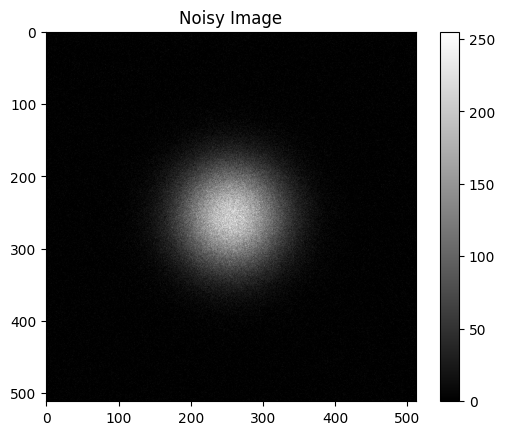

SNR after Gaussian Denoising: 4.430


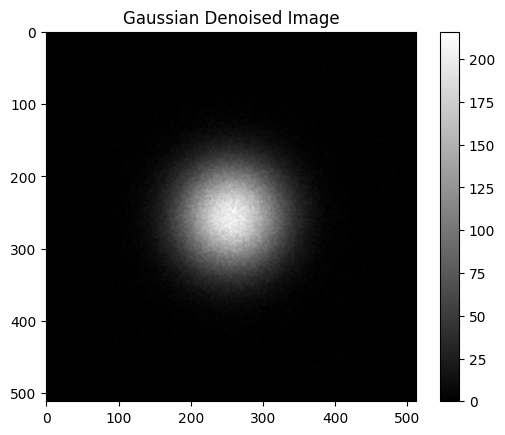

SNR after Median Denoising: 4.395


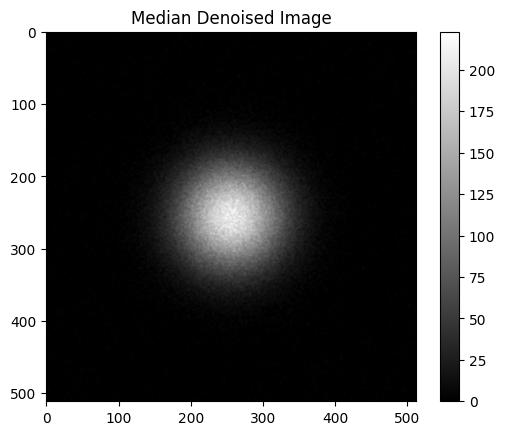

In [223]:
'''
Denoising of images using various techniques and SNR comparison before and after denoising
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_nl_means, estimate_sigma    

def calculate_snr(image):
    # We use a small patch in the center to avoid edge effects
    patch = image[200:300, 200:300].astype(np.float32)
    mean_signal = np.mean(patch)
    std_noise = np.std(patch)
    
    # Avoid division by zero
    if std_noise == 0: return 0
    return mean_signal / std_noise  

# Original Noisy Image
noisy_image = final_digital_image
snr_noisy = calculate_snr(noisy_image)
print(f"SNR of Noisy Image: {snr_noisy:.3f}")   
plt.imshow(noisy_image, cmap='gray')
plt.colorbar()
plt.title("Noisy Image")
plt.show()

# 1. Gaussian Filter Denoising
gaussian_denoised = gaussian_filter(noisy_image, sigma=1)
snr_gaussian = calculate_snr(gaussian_denoised)
print(f"SNR after Gaussian Denoising: {snr_gaussian:.3f}")
plt.imshow(gaussian_denoised, cmap='gray')
plt.colorbar()  
plt.title("Gaussian Denoised Image")
plt.show()

# # 2. Non-Local Means Denoising
# sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))
# nlm_denoised = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,
#                                  patch_size=5, patch_distance=6, multichannel=False)
# snr_nlm = calculate_snr(nlm_denoised)
# print(f"SNR after Non-Local Means Denoising: {snr_nlm:.3f}")
# plt.imshow(nlm_denoised, cmap='gray')
# plt.colorbar()  
# plt.title("Non-Local Means Denoised Image")
# plt.show()

# 3. Median Filter Denoising
from scipy.ndimage import median_filter
median_denoised = median_filter(noisy_image, size=3)
snr_median = calculate_snr(median_denoised)
print(f"SNR after Median Denoising: {snr_median:.3f}")
plt.imshow(median_denoised, cmap='gray')
plt.colorbar()  
plt.title("Median Denoised Image")
plt.show()











In [218]:
'''
Analysing image to test techniques like PTC, read noise estimation, gain estimation, dark current estimation
'''



'\nAnalysing image to test techniques like PTC, read noise estimation, gain estimation, dark current estimation\n'